## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

In [94]:
# Imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Read in the data.

In [95]:
data = pd.read_csv('../4.02-lab-classification-model-evaluation-master/chronic_kidney_disease_full.csv')

In [96]:
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', None)

In [97]:
data.head(2)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd


In [98]:
data['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: I would be interested in checking out the relationship between bp age and class. Age and blood pressure are features that most people would know so it would be interesting to see if certain ranges of blood pressure relate to people who have ckd.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [99]:
data.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [100]:
data.shape

(400, 25)

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.  
**Note:** You can clean your data below in step 4 when building a model!

**Answer:**
- If I dropped every row that contained at least one missing value we would only have 158 rows left in our dataset after dropping 152 rows.   
- One downsides of this would be that now we have a much smaller dataset to train and test our model on which will make our model less accurate to future data.   
- Another downside of this would be that we are losing very important information that is crucial to predicting whether or not someone has ckd.  

In [101]:
data.head(1)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd


In [102]:
data.shape

(400, 25)

In [82]:
data.dropna().shape

(158, 25)

In [109]:
data['su'].unique()

array([ 0.,  3.,  4.,  1., nan,  2.,  5.])

In [103]:
data.isna().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [67]:
cont_cols = data.describe().columns

In [93]:
# data['pot'].replace(47, data['pot'].mean(), inplace = True)
# data['pot'].replace(39, data['pot'].mean(), inplace = True)

In [85]:
data.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.491433,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,2.099849,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,39.000000,17.800000,54.000000,26400.000000,8.000000


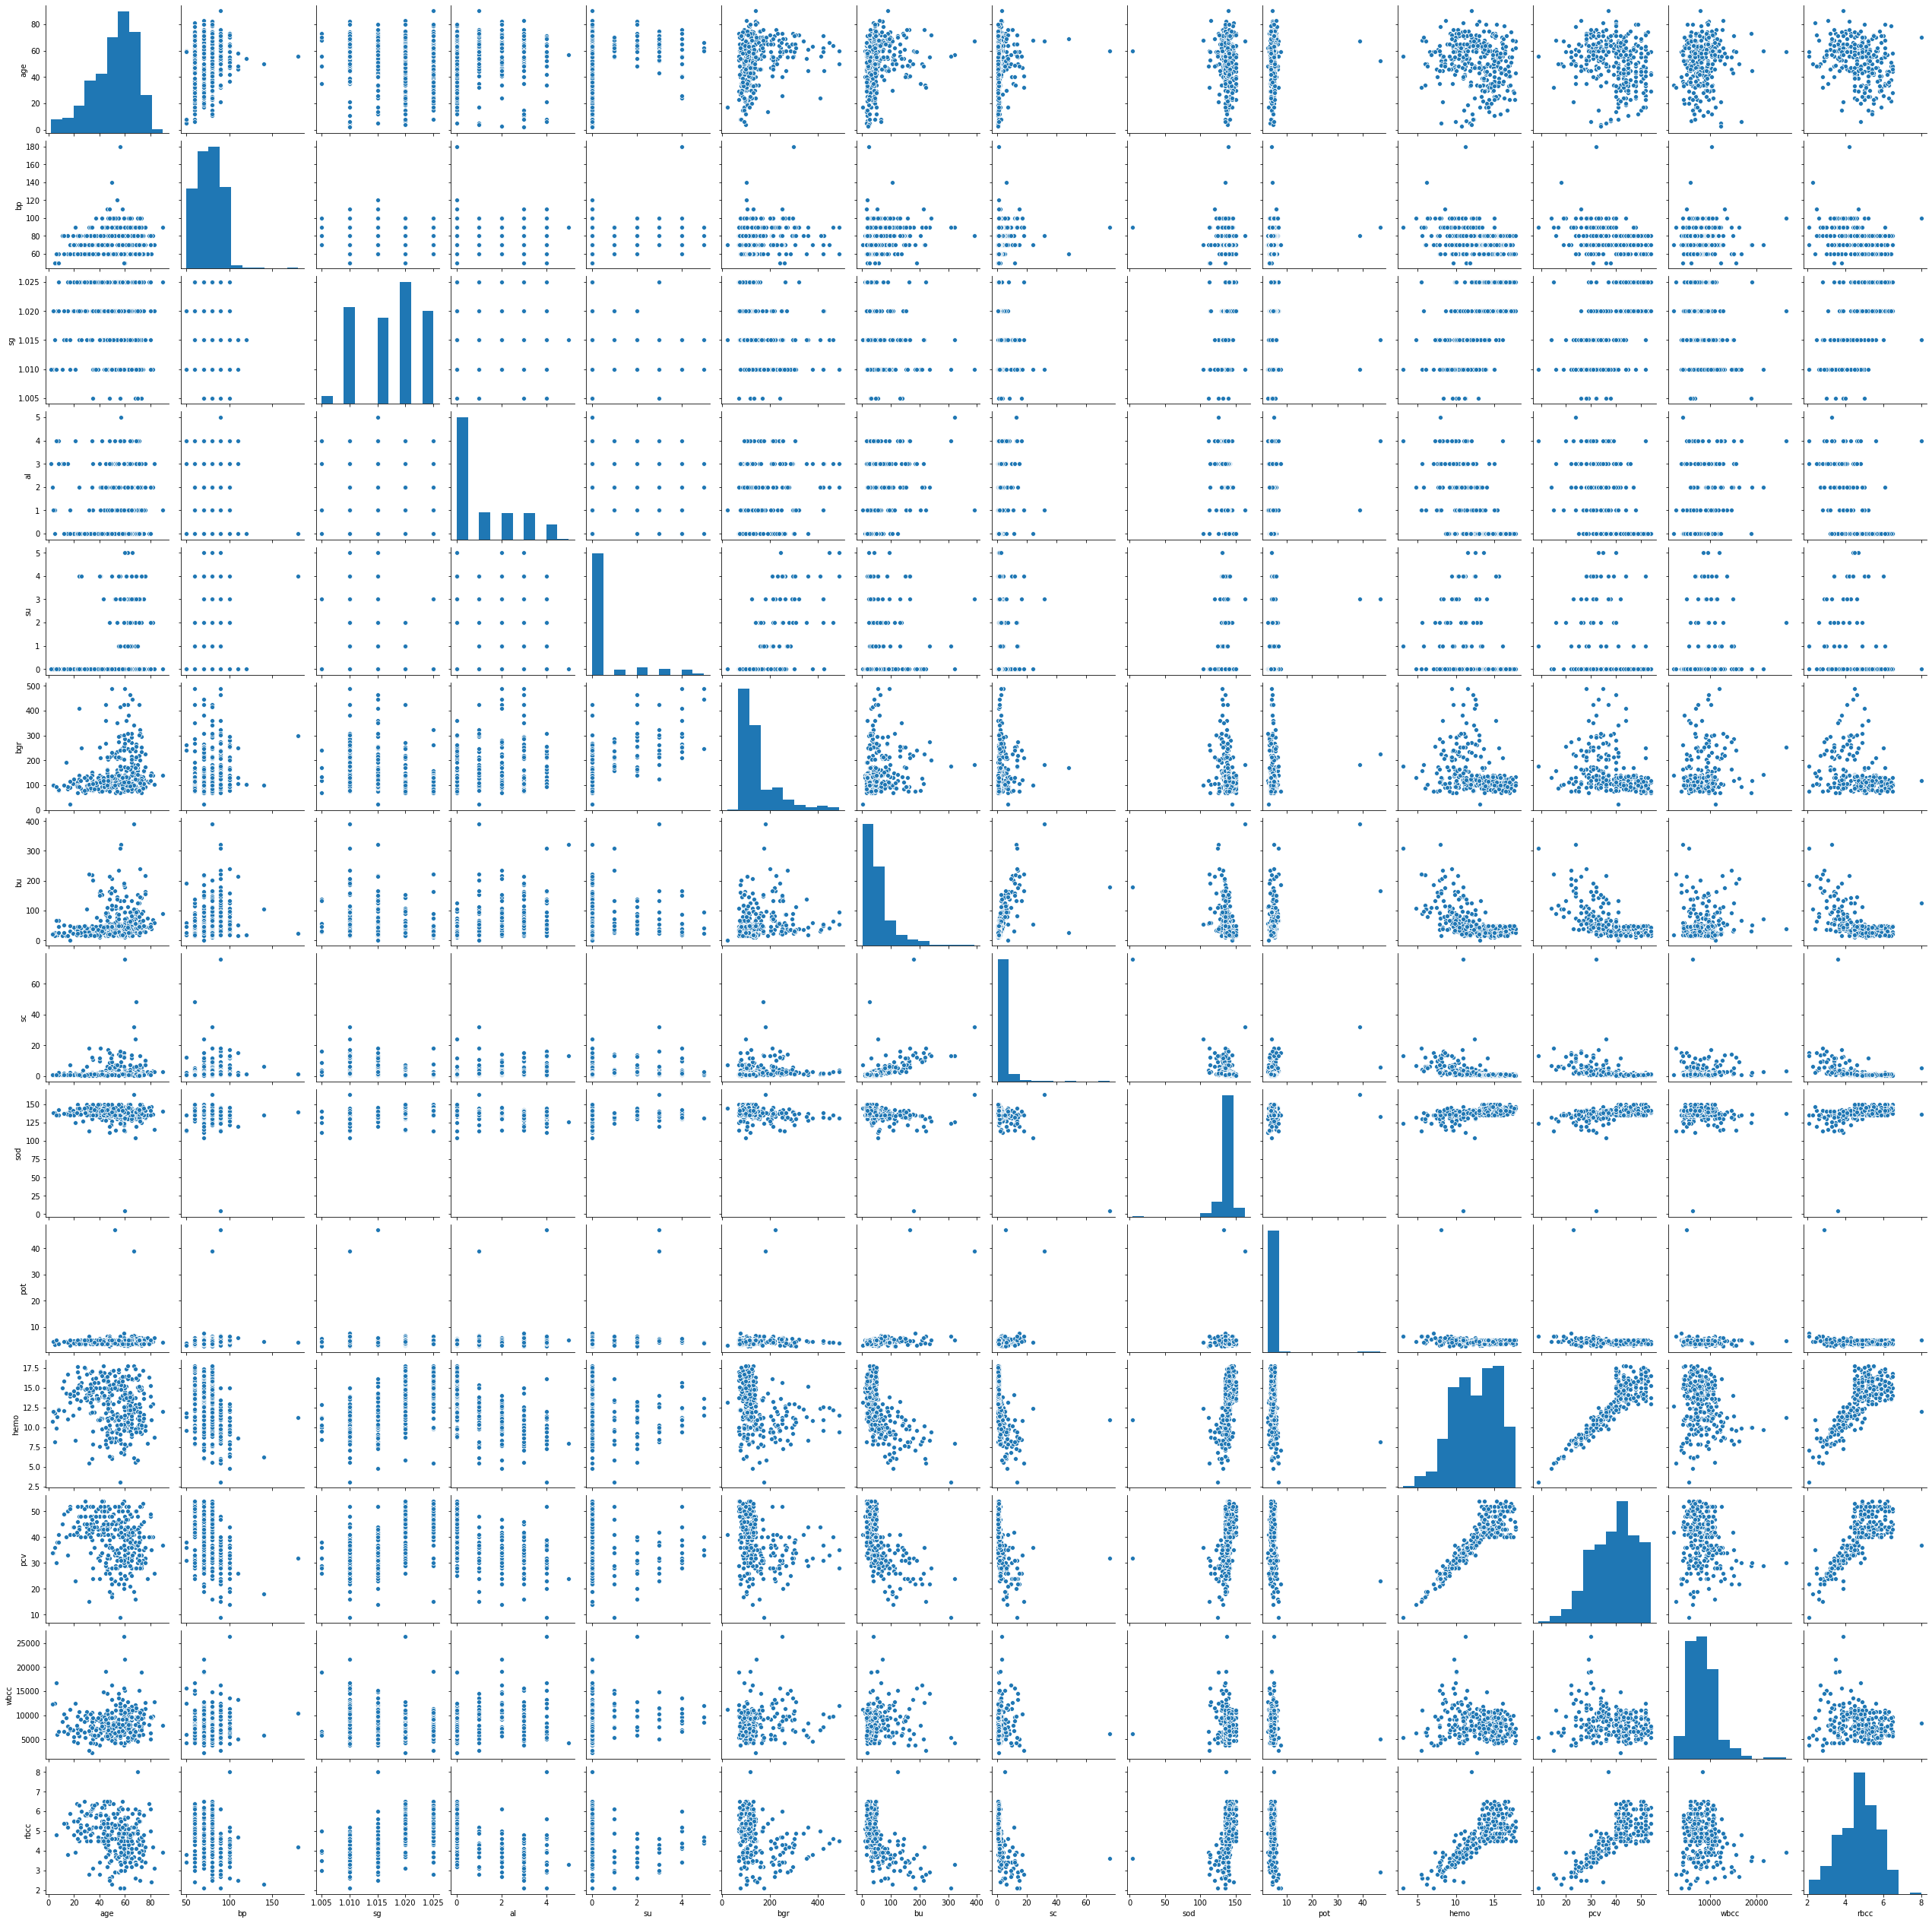

In [45]:
sns.pairplot(data[cont_cols])

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a "model" where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer:

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:

### 9. Suppose that I want to construct a "model" where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer:

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer:

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint 1: Remember to do a train/test split!  
> Hint 2: This will require data cleaning first!

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Think about which data is used for model evaluation. Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer:

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer:

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!). The [`pandas .sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method may be _very_ useful here!
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with just over 200,000 observations, of which only about 0.075% are non-CKD individuals.

### 22. What do you expect will be the impact of unbalanced classes on your logistic regression model?

**Answer:**

### 23. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. 
> Be sure to look at how well it performs on non-CKD data.

### 24. Do the results of your model above align with your expectations of the impact of unbalanced classes on logistic regression? If not, do you have any thoughts on why your model, considering the data, is performing how it is?

**Answer:**

---

## Step 6: Answer the problem. (Nothing to do here...except think about it!)

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!